In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import butter, lfilter
from scipy.fft import fft, fftshift
import os
import string # Needed for score_decoded_string

# --- WAV File and SDR Configuration ---
# IMPORTANT: Update this path to your actual WAV file.
WAV_FILE_PATH = 'baseband_433123259Hz_12-22-59_30-07-2025.wav' # Your current WAV file
sdr_sample_rate_ref = 2.4e6 # Reference: SDR sample rate (samples per second).

# --- FSK Parameters (for plotting reference lines) ---
# These values are taken from your Arduino code and are used to draw
# reference lines on the instantaneous frequency plot.
fsk_bit_rate_bps = 9600.0
fsk_freq_dev_hz = 10000.0
f_mark = fsk_freq_dev_hz
f_space = -fsk_freq_dev_hz # Corrected: Uses fsk_freq_dev_hz

# --- Parameters for finding the best signal chunk ---
WAV_CHUNK_SIZE_FOR_ANALYSIS = 2**15 # Size of chunks for initial power analysis
FFT_SIZE_FOR_ANALYSIS = 2048 # FFT size for power spectrum calculation
OVERLAP_PERCENT_FOR_ANALYSIS = 50 # Overlap for FFT windows (e.g., 50% overlap)

# Define a dummy longest expected string length for chunk sizing,
# as the actual string content is not used for decoding here.
# This ensures the extracted chunk is large enough to contain a message.
LONGEST_EXPECTED_STRING_LENGTH = 10 # A reasonable length for a short message
# Define expected strings for scoring (assuming you might want to uncomment decoding later)
EXPECTED_STRINGS = ["Hello World!", "TEST MESSAGE"]

# Calculate samples per bit globally, using the reference sample rate
samples_per_bit_float = sdr_sample_rate_ref / fsk_bit_rate_bps


# --- Function to read WAV file data and extract I/Q ---
def read_iq_wav(file_path):
    """
    Reads an I/Q WAV file recorded by SDR++ (Baseband, Float32)
    and returns complex I/Q data and sample rate.
    """
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}. Please ensure the path is correct.")
        return None, None
    try:
        sample_rate, data = wavfile.read(file_path)
        print(f"Loaded WAV file. Sample Rate: {sample_rate} Hz, Shape: {data.shape}, Dtype: {data.dtype}")
        # Ensure the sdr_sample_rate_ref matches the actual_wav_sample_rate for consistency
        global sdr_sample_rate_ref # Declare global to modify it
        if sdr_sample_rate_ref != sample_rate:
            print(f"WARNING: sdr_sample_rate_ref ({sdr_sample_rate_ref}) does not match actual WAV sample rate ({sample_rate}). Updating sdr_sample_rate_ref.")
            sdr_sample_rate_ref = sample_rate
        # Recalculate samples_per_bit_float if sdr_sample_rate_ref changes
        global samples_per_bit_float
        samples_per_bit_float = sdr_sample_rate_ref / fsk_bit_rate_bps
        print(f"DEBUG: samples_per_bit_float recalculated to {samples_per_bit_float:.2f}")

        if data.ndim < 2 or data.shape[1] < 2:
            raise ValueError(f"WAV file is not stereo ({data.ndim}D, channels: {data.shape[1] if data.ndim > 0 else 'N/A'}). Cannot extract I/Q.")
        i_component = data[:, 0]
        q_component = data[:, 1]
        if data.dtype == np.int16:
            max_int_val = np.iinfo(np.int16).max
            i_component = i_component.astype(np.float32) / max_int_val
            q_component = q_component.astype(np.float32) / max_int_val
            print("Converted Int16 to normalized Float32.")
        elif data.dtype == np.float32:
            i_component = i_component.astype(np.float32)
            q_component = q_component.astype(np.float32)
            print("Data already Float32.")
        else:
            print(f"Warning: Unexpected WAV sample data type: {data.dtype}. Attempting conversion to float32 anyway.")
            i_component = i_component.astype(np.float32)
            q_component = q_component.astype(np.float32)
        iq_samples_full = i_component + 1j * q_component
        print(f"Extracted {len(iq_samples_full)} complex samples.")
        return iq_samples_full, sample_rate
    except Exception as e:
        print(f"ERROR: An error occurred while reading WAV file: {e}")
        return None, None

# --- Function to find the chunk with the highest signal power ---
def find_best_signal_chunk(full_iq_samples, sample_rate, chunk_size, fft_size, overlap_percent):
    """
    Analyzes the full IQ samples to find the chunk with the highest peak power in its spectrum.
    This simulates finding the 'brightest line' in a waterfall plot.
    """
    print(f"\nAnalyzing full IQ data to find the chunk with the highest signal power...")
    max_peak_power_db = -np.inf
    best_chunk_start_idx = -1
    best_chunk_samples = None

    overlap = int(fft_size * overlap_percent / 100)
    step_size = fft_size - overlap

    # Iterate through the data, calculating spectrum for each window
    for i in range(0, len(full_iq_samples) - fft_size, step_size):
        chunk = full_iq_samples[i : i + fft_size]
        if len(chunk) < fft_size: # Ensure full FFT window
            continue

        # Calculate power spectrum for the current chunk
        yf = fft(chunk * np.hanning(fft_size))
        power_spectrum_db = 20 * np.log10(np.abs(fftshift(yf)) + 1e-10) # Add small epsilon to avoid log(0)
        # Find the peak power in this spectrum
        current_peak_power_db = np.max(power_spectrum_db)

        if current_peak_power_db > max_peak_power_db:
            max_peak_power_db = current_peak_power_db
            best_chunk_start_idx = i
            # Extract a larger chunk around the peak for plotting
            # Ensure it's at least the size needed for a message (LONGEST_EXPECTED_STRING_LENGTH)
            min_samples_for_string = int(LONGEST_EXPECTED_STRING_LENGTH * 8 * samples_per_bit_float)
            # Take a chunk of `chunk_size` around the peak, ensuring it's large enough for a message
            # and doesn't go out of bounds.
            end_idx_for_plot = best_chunk_start_idx + max(chunk_size, min_samples_for_string)
            if end_idx_for_plot > len(full_iq_samples):
                end_idx_for_plot = len(full_iq_samples)
            best_chunk_samples = full_iq_samples[best_chunk_start_idx : end_idx_for_plot]


    if best_chunk_start_idx != -1 and best_chunk_samples is not None:
        print(f"Found best signal chunk starting at sample {best_chunk_start_idx} with peak power {max_peak_power_db:.2f} dB.")
        print(f"This chunk has {len(best_chunk_samples)} samples.")
        return best_chunk_samples, best_chunk_start_idx
    else:
        print("No significant signal chunk found.")
        return None, None

# --- Function to apply frequency offset (THIS IS THE CONSISTENT ONE) ---
def apply_freq_offset(iq_data, sample_rate, center_freq_offset_hz):
    if center_freq_offset_hz == 0:
        return iq_data
    t = np.arange(len(iq_data)) / sample_rate
    # Convention: exp(-1j * 2 * pi * F_shift * t) shifts signal *down* by F_shift
    # So, a positive F_shift moves spectrum left (towards negative frequencies)
    # A negative F_shift moves spectrum right (towards positive frequencies)
    complex_exp = np.exp(-1j * 2 * np.pi * center_freq_offset_hz * t)
    return iq_data * complex_exp

# --- Function to plot the spectrum (FFT) ---
def plot_spectrum(ax, iq_data, sample_rate, title="Spectrum of Best Signal", center_freq_offset_hz=0):
    ax.clear()
    N = len(iq_data)
    if N == 0: return

    # *** Use the consistent apply_freq_offset function ***
    shifted_iq_data = apply_freq_offset(iq_data, sample_rate, center_freq_offset_hz)

    yf = fft(shifted_iq_data * np.hanning(N))
    xf = fftshift(np.fft.fftfreq(N, 1 / sample_rate))
    power_spectrum = np.abs(fftshift(yf))
    power_spectrum = power_spectrum / np.max(power_spectrum) if np.max(power_spectrum) > 0 else power_spectrum
    power_spectrum_db = 20 * np.log10(power_spectrum + 1e-10)

    ax.plot(xf / 1e3, power_spectrum_db)
    ax.set_xlabel("Frequency Offset (kHz)")
    ax.set_ylabel("Power (dB)")
    ax.set_title(title)
    ax.grid(True)
    ax.set_ylim(-100, 0) # Typical range for normalized power spectrum
    ax.set_xlim(-50, 50) # Full range as requested

# --- Function to plot instantaneous frequency ---
def plot_instantaneous_frequency(ax, iq_data, sample_rate, bit_rate, freq_dev, mark_freq, space_freq, title="Instantaneous Frequency of Best Signal", center_freq_offset_hz=0):
    if iq_data is None or sample_rate is None:
        print("Invalid I/Q data or sample rate provided for frequency plot.")
        return

    print(f"Plotting instantaneous frequency for {len(iq_data)} samples...")

    # *** Use the consistent apply_freq_offset function ***
    shifted_iq_data = apply_freq_offset(iq_data, sample_rate, center_freq_offset_hz)

    phase = np.unwrap(np.angle(shifted_iq_data))
    instantaneous_frequency = np.diff(phase) * (sample_rate / (2 * np.pi))

    nyquist = 0.5 * sample_rate
    cutoff_norm = (bit_rate * 2) / nyquist
    if cutoff_norm >= 1.0:
        filtered_frequency = instantaneous_frequency
    else:
        b, a = butter(5, cutoff_norm, btype='low')
        filtered_frequency = lfilter(b, a, instantaneous_frequency)
    print(f"Filtered Freq. Stats (Min/Max/Mean): {np.min(filtered_frequency):.2f}/{np.max(filtered_frequency):.2f}/{np.mean(filtered_frequency):.2f} Hz. Len: {len(filtered_frequency)}")

    time_axis = np.arange(len(filtered_frequency)) / sample_rate

    ax.plot(time_axis, filtered_frequency)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_title(title)
    ax.axhline(mark_freq, color='green', linestyle='--', label=f'Mark Freq ({mark_freq} Hz)')
    ax.axhline(space_freq, color='red', linestyle='--', label=f'Space Freq ({space_freq} Hz)')
    ax.legend()
    ax.grid(True)
    min_ylim = min(f_space, f_mark) - abs(f_space - f_mark) * 0.5
    max_ylim = max(f_space, f_mark) + abs(f_space - f_mark) * 0.5
    ax.set_ylim(min_ylim, max_ylim)

# --- Function to plot spectrogram (like a waterfall, but for a single chunk) ---
def plot_spectrogram(ax, iq_data, sample_rate, fft_size=256, overlap_percent=75, dynamic_range_db=80, center_freq_offset_hz=0):
    ax.clear()
    # *** Use the consistent apply_freq_offset function ***
    shifted_iq_data = apply_freq_offset(iq_data, sample_rate, center_freq_offset_hz)

    if len(shifted_iq_data) < fft_size:
        print("Not enough data for spectrogram. Increase chunk size or decrease FFT size.")
        return

    # Bandpass filter the IQ data for display ---
    fsk_bandwidth_for_filter_hz = (2 * fsk_freq_dev_hz + fsk_bit_rate_bps) * 1.5
    nyquist = 0.5 * sample_rate
    lowcut_norm = (-fsk_bandwidth_for_filter_hz / 2) / nyquist
    highcut_norm = (fsk_bandwidth_for_filter_hz / 2) / nyquist

    lowcut_norm = max(0.001, lowcut_norm)
    highcut_norm = min(0.999, highcut_norm)
    if lowcut_norm >= highcut_norm:
        filtered_iq_data = shifted_iq_data
    else:
        b_bp, a_bp = butter(4, [lowcut_norm, highcut_norm], btype='band', analog=False)
        filtered_iq_data = lfilter(b_bp, a_bp, shifted_iq_data)

    num_samples = len(filtered_iq_data)
    overlap = int(fft_size * overlap_percent / 100)
    step_size = fft_size - overlap

    num_windows = (num_samples - fft_size) // step_size + 1
    if num_windows <= 0:
        print("Not enough data for at least one FFT window for spectrogram.")
        return

    spectrogram_data = np.zeros((num_windows, fft_size))
    window = np.hanning(fft_size)

    for i in range(num_windows):
        start_idx = i * step_size
        end_idx = start_idx + fft_size
        if end_idx > num_samples:
            break

        chunk = filtered_iq_data[start_idx:end_idx] * window
        fft_result = np.fft.fftshift(np.fft.fft(chunk))
        power_spectrum = np.abs(fft_result)**2
        power_spectrum_db = 10 * np.log10(power_spectrum + 1e-10)
        spectrogram_data[i, :] = power_spectrum_db

    min_val = np.max(spectrogram_data) - dynamic_range_db
    spectrogram_data[spectrogram_data < min_val] = min_val
    freq_axis_khz = np.linspace(-sample_rate / 2, sample_rate / 2, fft_size) / 1000.0
    time_axis_seconds = np.linspace(0, (num_windows * step_size) / sample_rate, num_windows)

    im = ax.imshow(spectrogram_data, aspect='auto', cmap='jet',
                   extent=[freq_axis_khz[0], freq_axis_khz[-1], time_axis_seconds[-1], time_axis_seconds[0]])

    ax.set_title('Spectrogram of Best Signal Chunk (After Freq Correction & Bandpass)')
    ax.set_xlabel('Frequency Offset (kHz)')
    ax.set_ylabel('Time (s)')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlim(-50, 50)
    plt.colorbar(im, ax=ax, label='Power (dB)')


# --- Main part of the script ---
if __name__ == "__main__":
    print(f"Starting SDR signal analysis from WAV file: '{WAV_FILE_PATH}'")

    full_iq_samples, actual_sdr_sample_rate = read_iq_wav(WAV_FILE_PATH)

    if full_iq_samples is None:
        print("\nFailed to load WAV file. Exiting.")
        exit()

    sdr_sample_rate = actual_sdr_sample_rate # Use actual sample rate from WAV

    print(f"\nSearching for the chunk with the highest signal power...")
    best_signal_chunk, best_signal_chunk_start_idx = find_best_signal_chunk(
        full_iq_samples, sdr_sample_rate,
        WAV_CHUNK_SIZE_FOR_ANALYSIS, FFT_SIZE_FOR_ANALYSIS, OVERLAP_PERCENT_FOR_ANALYSIS
    )

    if best_signal_chunk is None:
        print("\nCould not find a significant signal chunk in the WAV file. Exiting.")
        exit()

    # --- IMPORTANT: Determine this offset from the SDR++ waterfall or by inspecting the raw IQ data ---
    # Based on your latest feedback and consistent observations, you achieved offset:
    # signal_center_offset_hz = -100000.0 (to center the signal)
    # This value will be used directly in the static plots.
    signal_center_offset_hz = -100000.0 # Your achieved offset for centering
    # -------------------------------------------------------------------------------------------------

    # Create a figure with three subplots (horizontal layout as requested previously)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6)) # Horizontal layout
    fig.suptitle(f"SDR Signal Analysis (Start Sample: {best_signal_chunk_start_idx})", y=1.05) # Adjusted suptitle position

    print(f"\nPlotting the spectrum of the brightest signal line...")
    plot_spectrum(
        ax1, # Pass the first subplot axis
        best_signal_chunk,
        sdr_sample_rate,
        title="Spectrum of Best Signal Chunk (After Freq Correction)",
        center_freq_offset_hz=signal_center_offset_hz # Apply corrected offset
    )

    print(f"\nPlotting the instantaneous frequency of the brightest signal line...")
    plot_instantaneous_frequency(
        ax2, # Pass the second subplot axis
        best_signal_chunk,
        sdr_sample_rate,
        fsk_bit_rate_bps,
        fsk_freq_dev_hz,
        f_mark,
        f_space,
        title="Instantaneous Frequency of Best Signal Chunk (After Freq Correction)",
        center_freq_offset_hz=signal_center_offset_hz # Apply corrected offset
    )

    print(f"\nPlotting the spectrogram of the brightest signal line...")
    plot_spectrogram(
        ax3, # Pass the third subplot axis
        best_signal_chunk,
        sdr_sample_rate,
        fft_size=256, # Smaller FFT size for better time resolution in spectrogram
        overlap_percent=75,
        dynamic_range_db=90,
        center_freq_offset_hz=signal_center_offset_hz # Apply corrected offset
    )

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()
    print("\nScript finished.")

Starting SDR signal analysis from WAV file: 'baseband_433123259Hz_12-22-59_30-07-2025.wav'
Loaded WAV file. Sample Rate: 2400000 Hz, Shape: (25807104, 2), Dtype: float32
DEBUG: samples_per_bit_float recalculated to 250.00
Data already Float32.
Extracted 25807104 complex samples.

Searching for the chunk with the highest signal power...

Analyzing full IQ data to find the chunk with the highest signal power...


KeyboardInterrupt: 

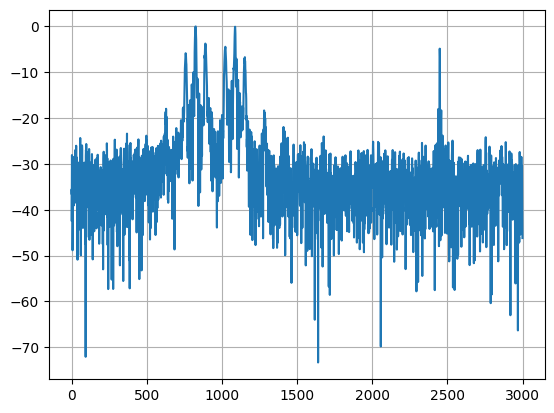

In [15]:
# --- Function to apply frequency offset (THIS IS THE CONSISTENT ONE) ---
def apply_freq_offset(iq_data, sample_rate, center_freq_offset_hz):
    if center_freq_offset_hz == 0:
        return iq_data
    t = np.arange(len(iq_data)) / sample_rate
    # Convention: exp(-1j * 2 * pi * F_shift * t) shifts signal *down* by F_shift
    # So, a positive F_shift moves spectrum left (towards negative frequencies)
    # A negative F_shift moves spectrum right (towards positive frequencies)
    complex_exp = np.exp(-1j * 2 * np.pi * center_freq_offset_hz * t)
    return iq_data * complex_exp
    
signal_center_offset_hz = -100000.0

N = len(best_signal_chunk)

# *** Use the consistent apply_freq_offset function ***
shifted_iq_data = apply_freq_offset(best_signal_chunk, sdr_sample_rate, signal_center_offset_hz)

yf = fft(shifted_iq_data * np.hanning(N))
xf = fftshift(np.fft.fftfreq(N, 1 / sdr_sample_rate))
power_spectrum = np.abs(fftshift(yf))
power_spectrum = power_spectrum / np.max(power_spectrum) if np.max(power_spectrum) > 0 else power_spectrum
power_spectrum_db = 20 * np.log10(power_spectrum + 1e-10)

strs=15300
ends = strs+3000
plt.plot(power_spectrum_db[strs:ends])
plt.grid(True)
    
plt.show()

In [3]:
shifted_samples = best_signal_chunk[strs:ends]
print(samples.shape)
sample_rate = sdr_sample_rate
freq_offset_hz = signal_center_offset_hz
freq_dev = fsk_freq_dev_hz
mark_freq =  f_mark
space_freq = f_space
bit_rate = fsk_bit_rate_bps
target_string_length = 10
start_sample_offset_within_chunk = 0 

phase_diff = np.angle(shifted_samples[1:] * np.conj(shifted_samples[:-1]))
instantaneous_frequency = phase_diff * (sample_rate / (2 * np.pi))

nyquist = 0.5 * sample_rate
# Filter cutoff based on FSK signal characteristics (e.g., 2 * Fdev)
filter_cutoff_hz = freq_dev * 2 # Use 2 times frequency deviation (20kHz for 10kHz dev)
cutoff_norm = filter_cutoff_hz / nyquist
filter_order = 8

if cutoff_norm >= 1.0:
    filtered_frequency = instantaneous_frequency
    if debug_decode: print(f"WARNING: LPF cutoff ({filter_cutoff_hz:.1f} Hz) is too high (>{nyquist:.1f} Hz). Skipping filter.")
else:
    b, a = butter(filter_order, cutoff_norm, btype='low')
    filtered_frequency = lfilter(b, a, instantaneous_frequency)
    
threshold_freq = (mark_freq + space_freq) / 2
samples_per_bit_calculated = sample_rate / bit_rate

raw_bits = []
num_bits_to_decode = target_string_length * 8
current_sample_index_float = float(start_sample_offset_within_chunk + samples_per_bit_calculated / 2)


for bit_count_in_loop in range(1000):
    sample_index = int(current_sample_index_float)
    if sample_index < len(filtered_frequency):
        bit = 1 if filtered_frequency[sample_index] > threshold_freq else 0
        raw_bits.append(bit)
    else:
        break # Ran out of samples

    current_sample_index_float += samples_per_bit_calculated


decoded_bytes = bytearray()
byte_value = 0
bit_in_byte_count = 0

for bit in raw_bits:
    byte_value |= (bit << bit_in_byte_count)
    bit_in_byte_count += 1
    if bit_in_byte_count == 8:
        decoded_bytes.append(byte_value)
        byte_value = 0
        bit_in_byte_count = 0


decoded_bytes.decode('ascii', errors='replace')

NameError: name 'samples' is not defined

Директорія для графіків вже існує: 'sdr_analysis_plots'
Запуск генерації водоспадного графіку з WAV-файлу: 'baseband_433123259Hz_12-22-59_30-07-2025.wav'
Завантажено весь WAV-файл: 25807104 комплексних вибірок з частотою 2400000 Гц.

Крок 1: Застосування початкового зміщення частоти -111550.41 Гц до повних даних I/Q для побудови графіків...
Крок 2: Обчислення миттєвої частоти для всього зміщеного сигналу (для кореляції)...
DEBUG: Миттєва частота зменшена з 25807103 до 2580711 вибірок для кореляції.
Крок 3: Генерація 16-бітового шаблону частоти преамбули (0101...).
Довжина шаблону преамбули (зменшений): 400 вибірок.
Крок 4: Виконання крос-кореляції для пошуку початків пакетів на зменшених даних...
DEBUG_CORR: Макс. кореляція: 59541209.81, Поріг: 47632967.85
Крок 4: Виявлено 7 потенційних початкових індексів СПЛЕСКУ ПОВІДОМЛЕННЯ (повний масштаб): [51420, 3788480, 7193680, 12865820, 16861310, 21318380, 25100210]

Генерація оглядових даних водоспаду для 10485760 вибірок...
Дані I/Q скороче

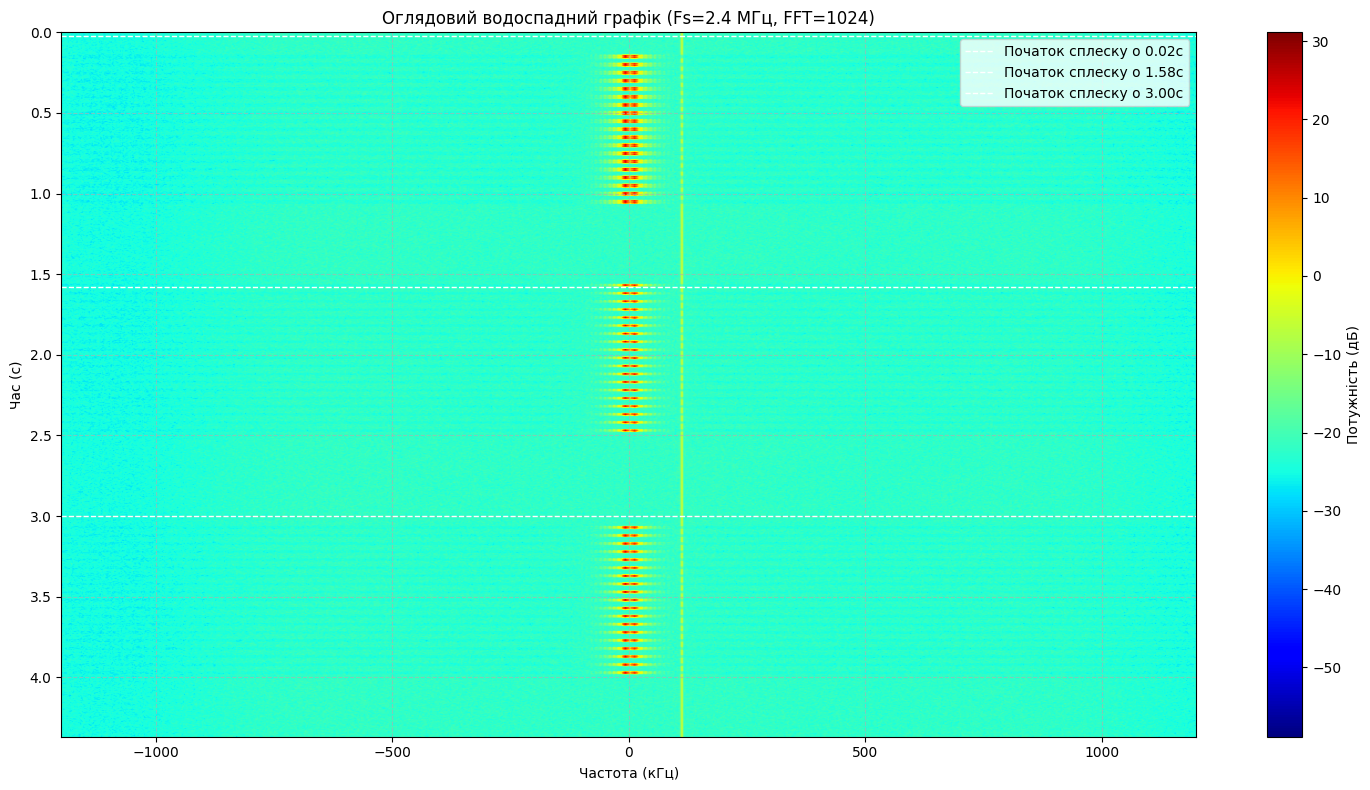

Оглядовий водоспад збережено як 'sdr_analysis_plots/overview_waterfall.png'

Побудова збільшених водоспадних графіків (з накладеною середньою частотою) та хроматичних стрічок усередненої миттєвої частоти...

Генерація збільшеного водоспаду для Сплеску 1 (вибірки з 50170 по 2691420)...
DEBUG: len(current_burst_inst_freq) = 2641249
DEBUG: INST_FREQ_AVG_WINDOW_SAMPLES = 250
DEBUG: INST_FREQ_AVG_OVERLAP_PERCENT = 50
DEBUG_STRIP: len(mean_freqs_burst) = 21128
DEBUG_STRIP: mean_freq_time_points_absolute min/max: 0.020956s to 1.121321s

--- Декодування Сплеску 1 ---
  Використаний порядок бітів: MSB-first
  Зміщення синхронізації бітів: 0 точок (mean_freqs)
  Декодовані біти (довжина: 160):
  11101111 01010111 11001111 00011001 10111101 10111111 11111011 10000011 11001000 00011111 11011001 11111011 11001011 01101111 00011110 10011100 01110111 01010101 10001011 01011111
  Декодована ASCII стрічка: '.W...........o..wU._'
----------------------------
  Автокореляція не виявила чітких піків для о

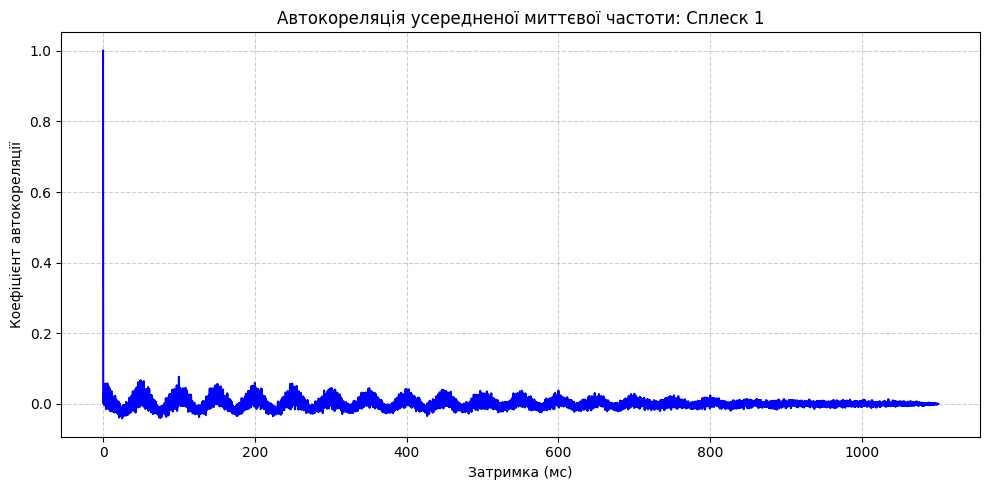

Графік автокореляції збережено як 'sdr_analysis_plots/burst_1_autocorrelation.png'


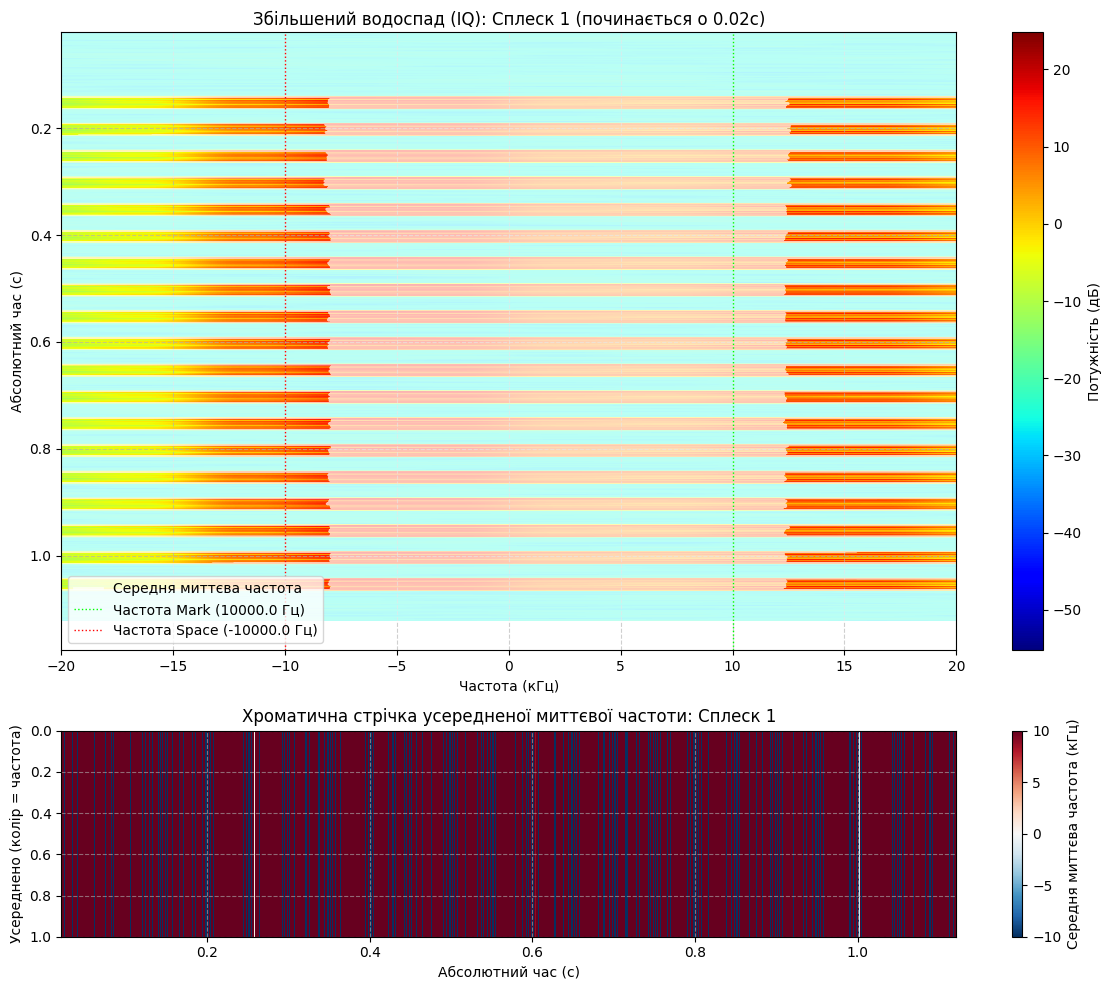

Аналіз сплеску 1 збережено як 'sdr_analysis_plots/burst_1_analysis.png'

Генерація збільшеного водоспаду для Сплеску 2 (вибірки з 3787230 по 6428480)...
DEBUG: len(current_burst_inst_freq) = 2641249
DEBUG: INST_FREQ_AVG_WINDOW_SAMPLES = 250
DEBUG: INST_FREQ_AVG_OVERLAP_PERCENT = 50
DEBUG_STRIP: len(mean_freqs_burst) = 21128
DEBUG_STRIP: mean_freq_time_points_absolute min/max: 1.578065s to 2.678429s

--- Декодування Сплеску 2 ---
  Використаний порядок бітів: LSB-first
  Зміщення синхронізації бітів: 0 точок (mean_freqs)
  Декодовані біти (довжина: 160):
  10111111 11111011 10110111 11100110 11001111 00101001 11111110 11001111 11100001 11101111 10101100 01101100 00011001 10010010 01111111 11111001 10010111 00110010 10101010 10101000
  Декодована ASCII стрічка: '...g......56.I...LU.'
----------------------------
  Автокореляція не виявила чітких піків для оцінки бітрейту.


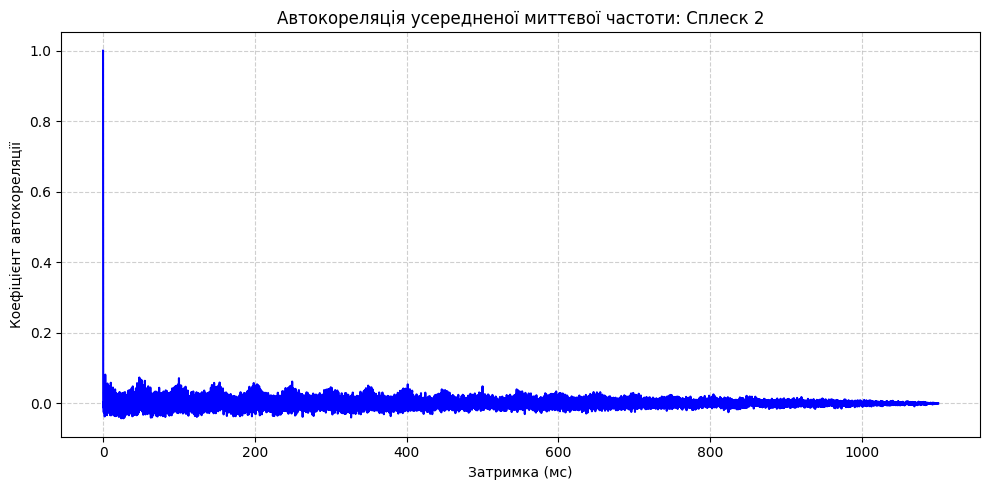

Графік автокореляції збережено як 'sdr_analysis_plots/burst_2_autocorrelation.png'


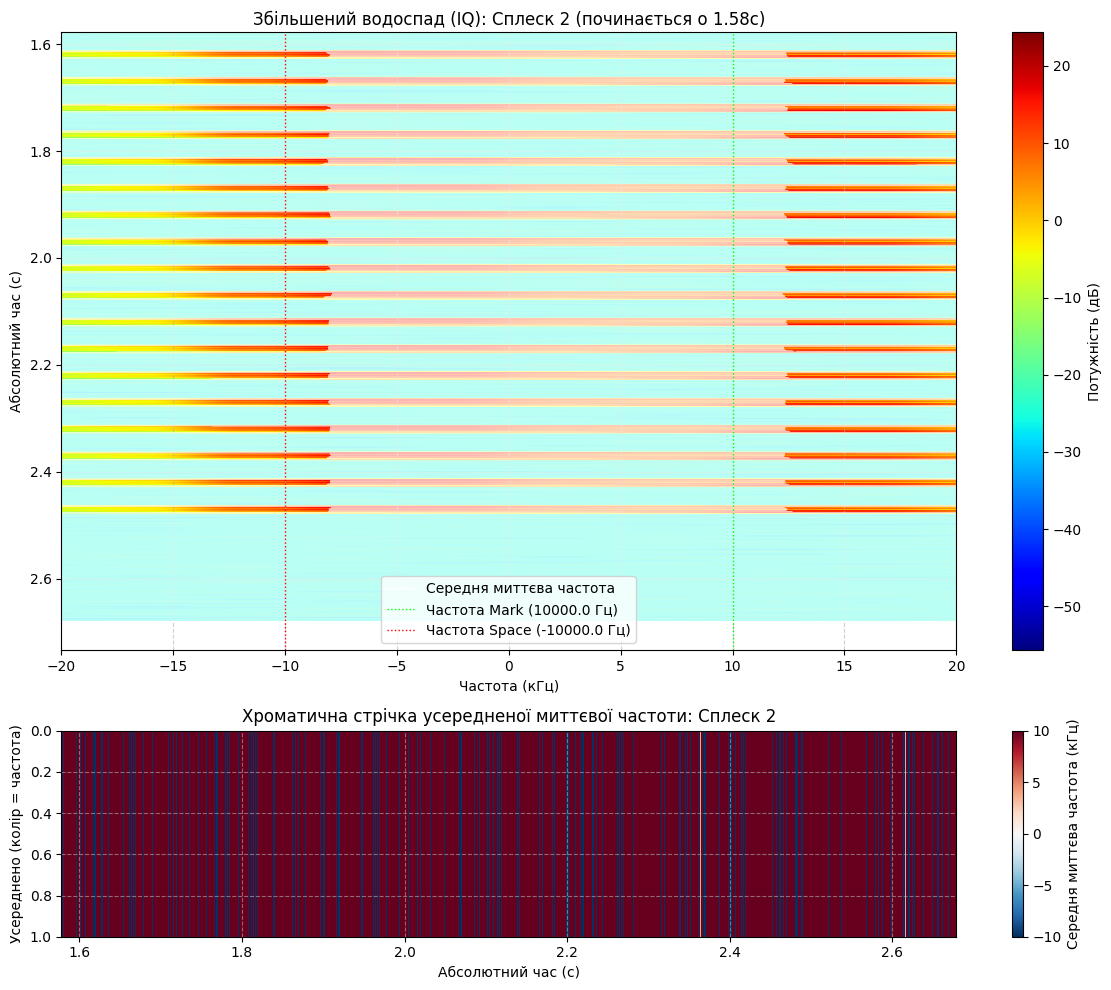

Аналіз сплеску 2 збережено як 'sdr_analysis_plots/burst_2_analysis.png'

Генерація збільшеного водоспаду для Сплеску 3 (вибірки з 7192430 по 9833680)...
DEBUG: len(current_burst_inst_freq) = 2641249
DEBUG: INST_FREQ_AVG_WINDOW_SAMPLES = 250
DEBUG: INST_FREQ_AVG_OVERLAP_PERCENT = 50
DEBUG_STRIP: len(mean_freqs_burst) = 21128
DEBUG_STRIP: mean_freq_time_points_absolute min/max: 2.996898s to 4.097263s

--- Декодування Сплеску 3 ---
  Використаний порядок бітів: MSB-first
  Зміщення синхронізації бітів: 0 точок (mean_freqs)
  Декодовані біти (довжина: 160):
  11001111 01110010 10101011 11001111 01101011 10111100 11101001 00001001 11100100 11100111 01000000 11111111 11111111 00110111 11111111 00011100 11011000 11101111 11111100 11111100
  Декодована ASCII стрічка: '.r..k..	..@..7......'
----------------------------
  Автокореляція не виявила чітких піків для оцінки бітрейту.


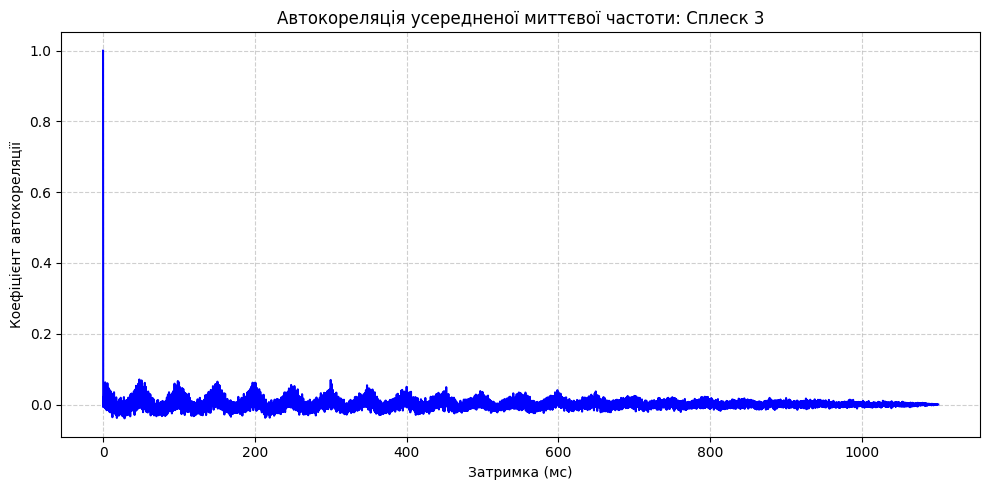

Графік автокореляції збережено як 'sdr_analysis_plots/burst_3_autocorrelation.png'


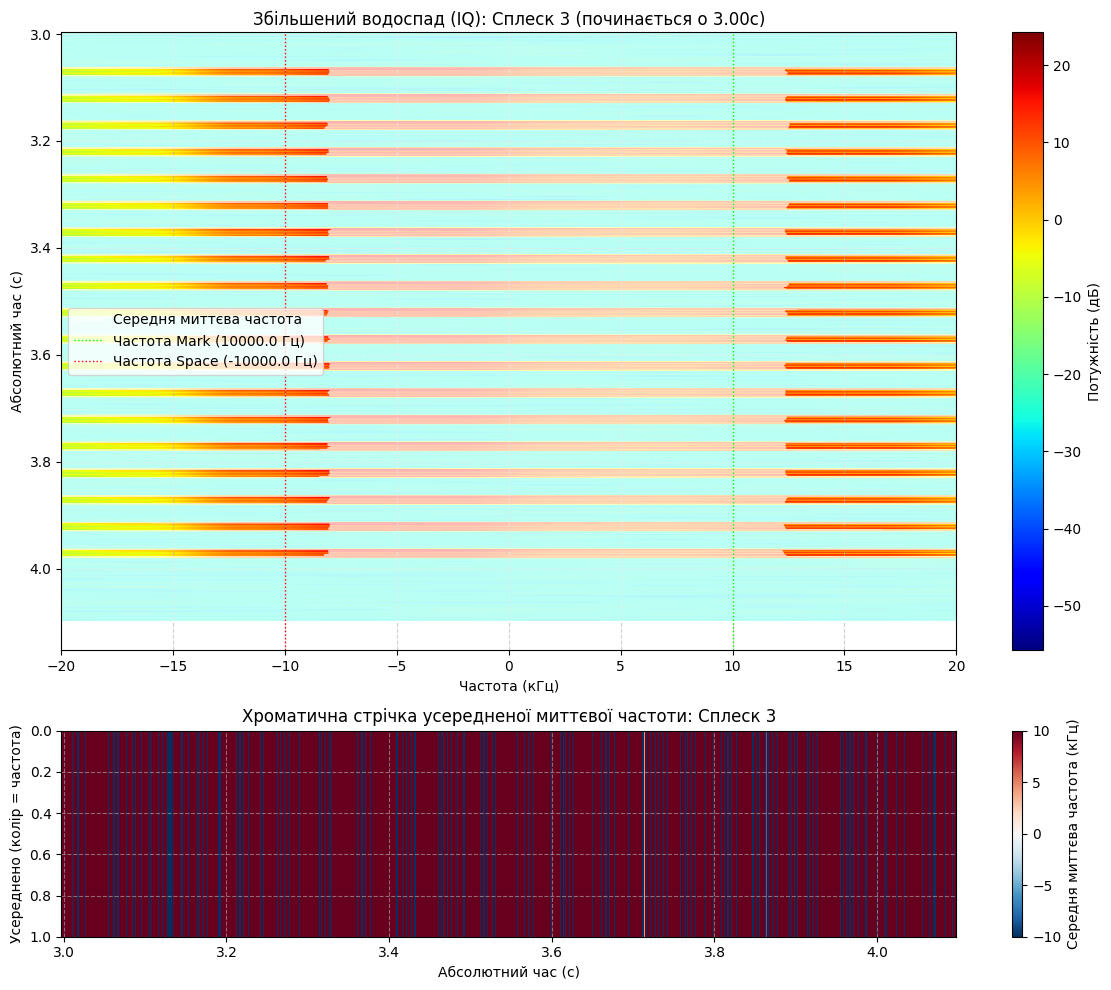

Аналіз сплеску 3 збережено як 'sdr_analysis_plots/burst_3_analysis.png'

Виконання скрипта завершено. Всі графіки збережено у папці 'sdr_analysis_plots'.


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import fft, fftshift
from scipy.signal import correlate, find_peaks # Додано find_peaks
import os

# --- WAV File та конфігурація SDR ---
WAV_FILE_PATH = 'baseband_433123259Hz_12-22-59_30-07-2025.wav'
sdr_sample_rate_ref = 2.4e6 # SDR sample rate in Hz

# --- FSK Parameters (з вашого коду Arduino) ---
fsk_bit_rate_bps = 9600.0   # FSK Bit Rate in bits per second (МОЖЛИВО, ПОТРЕБУЄ ТОЧНОГО НАЛАШТУВАННЯ)
fsk_freq_dev_hz = 10000.0   # FSK Frequency Deviation in Hz (МОЖЛИВО, ПОТРЕБУЄ ТОЧНОГО НАЛАШТУВАННЯ)
f_mark = fsk_freq_dev_hz
f_space = -fsk_freq_dev_hz

# --- Структура пакетів / повідомлень з коду Arduino (для виявлення) ---
PREAMBLE_BITS = 16
PREAMBLE_PATTERN = np.array([0, 1] * (PREAMBLE_BITS // 2))

MESSAGE_LENGTHS_CHARS = [12, 20, 10] # Для розрахунку максимальної довжини пакету
MAX_MESSAGE_LENGTH_BITS = max(MESSAGE_LENGTHS_CHARS) * 8 # Максимальна довжина повідомлення в бітах

samples_per_bit_float = sdr_sample_rate_ref / fsk_bit_rate_bps
SAMPLES_PER_BIT = int(samples_per_bit_float)

PACKET_TOTAL_SAMPLES_MAX = PACKET_TOTAL_BITS_MAX * SAMPLES_PER_BIT # Max samples per full packet
PACKET_PROCESSING_BUFFER_SAMPLES = int(SAMPLES_PER_BIT * 5) # Margin for timing

# --- Параметри декодування (для початкового зміщення частоти) ---
FINAL_CENTER_FREQ_OFFSET_HZ = -111550.41 # Ваш найкращий зсув з попередніх запусків (МОЖЛИВО, ПОТРЕБУЄ ТОЧНОГО НАЛАШТУВАННЯ)

# --- Параметри кореляції (для пошуку сплесків на водоспаді) ---
CORRELATION_THRESHOLD_FACTOR = 0.8 # Вищий поріг для суворішого виявлення
DOWNSAMPLE_FACTOR_FOR_CORRELATION = 10 # Зменшення частоти дискретизації на 10 для швидкості кореляції

# --- ОЧІКУВАНІ ЧАСОВІ ПАРАМЕТРИ З АРДУЇНО ---
ARDUINO_MESSAGE_BURST_DURATION_MS = 1000 # Тривалість одного блоку повідомлень (наприклад, 1 секунда)
ARDUINO_PAUSE_DURATION_MS = 500 # Тривалість паузи між блоками повідомлень (наприклад, 0.5 секунди)


# --- Параметри водоспадного графіку (для IQ даних) ---
WATERFALL_FFT_SIZE = 1024 # Розмір кожного вікна FFT для водоспаду (степінь 2)
WATERFALL_OVERLAP_PERCENT = 75
WATERFALL_DYNAMIC_RANGE_DB = 90 # Динамічний діапазон у дБ

# Обмежте загальну кількість вибірок для побудови оглядового водоспаду
MAX_WATERFALL_SAMPLES_TO_PLOT = 10 * 1024 * 1024 # 10 мільйонів вибірок

# --- Параметри збільшеного водоспаду (для IQ даних) ---
ZOOM_WATERFALL_FFT_SIZE = 512 # Менший розмір FFT для кращої роздільної здатності за часом при збільшенні
ZOOM_WATERFALL_OVERLAP_PERCENT = 85 # Вище перекриття для більш плавного збільшення
ZOOM_WATERFALL_DYNAMIC_RANGE_DB = 80 # Налаштування динамічного діапазону для чіткості збільшення
ZOOM_BURST_DURATION_SAMPLES = int(ARDUINO_MESSAGE_BURST_DURATION_MS / 1000.0 * sdr_sample_rate_ref * 1.1) # Тільки активний сплеск + буфер

# --- Параметри для усереднення миттєвої частоти ---
# ВИПРАВЛЕНО: Розмір вікна повернуто до 1 біта для коректного декодування
INST_FREQ_AVG_WINDOW_BITS = 1 # Розмір вікна для усереднення миттєвої частоти в бітах. 1 біт = SAMPLES_PER_BIT вибірок.
INST_FREQ_AVG_WINDOW_SAMPLES = int(INST_FREQ_AVG_WINDOW_BITS * SAMPLES_PER_BIT)
INST_FREQ_AVG_OVERLAP_PERCENT = 50 # Перекриття для усереднення миттєвої частоти

# --- Налаштування для збереження графіків ---
PLOTS_OUTPUT_DIR = 'sdr_analysis_plots' # Назва папки для збереження графіків

# ==================================================================================================
#                       !!! ВСІ ДОПОМІЖНІ ФУНКЦІЇ ВИЗНАЧЕНІ ТУТ ВГОРІ !!!
# ==================================================================================================

def read_iq_wav_full(file_path):
    """Читає весь I/Q WAV-файл."""
    if not os.path.exists(file_path):
        print(f"Помилка: Файл не знайдено за шляхом {file_path}.")
        return None, None
    try:
        sample_rate, data = wavfile.read(file_path)
        if data.ndim < 2 or data.shape[1] < 2:
            raise ValueError(f"WAV-файл не стерео. Форма: {data.shape}. Неможливо вилучити I/Q.")
        i_component = data[:, 0]
        q_component = data[:, 1]
        if data.dtype == np.int16:
            max_int_val = np.iinfo(np.int16).max
            i_component = i_component.astype(np.float32) / max_int_val
            q_component = q_component.astype(np.float32) / max_int_val
        elif data.dtype != np.float32:
            i_component = i_component.astype(np.float32)
            q_component = q_component.astype(np.float32)
        iq_samples_full = i_component + 1j * q_component
        print(f"Завантажено весь WAV-файл: {len(iq_samples_full)} комплексних вибірок з частотою {sample_rate} Гц.")
        return iq_samples_full, sample_rate
    except Exception as e:
        print(f"ПОМИЛКА під час читання повного WAV-файлу: {e}")
        return None, None

def apply_freq_offset(iq_data, sample_rate, center_freq_offset_hz):
    """Застосовує зміщення частоти до комплексних I/Q даних."""
    if center_freq_offset_hz == 0:
        return iq_data
    t = np.arange(len(iq_data)) / sample_rate
    complex_exp = np.exp(-1j * 2 * np.pi * center_freq_offset_hz * t)
    return iq_data * complex_exp

def calculate_instantaneous_frequency(iq_data, sample_rate):
    """Обчислює миттєву частоту з комплексних I/Q вибірок за допомогою різниці фаз."""
    phase_diff = np.angle(iq_data[1:] * np.conj(iq_data[:-1]))
    instantaneous_frequency = phase_diff * (sample_rate / (2 * np.pi))
    return instantaneous_frequency

def generate_preamble_freq_template(preamble_pattern, samples_per_bit, f_mark, f_space):
    """
    Генерує ідеальний шаблон миттєвої частоти преамбули на основі бітового шаблону.
    """
    template_list = []
    for bit in preamble_pattern:
        freq = f_mark if bit == 1 else f_space
        template_list.extend([freq] * samples_per_bit)
    return np.array(template_list)

def find_packet_starts_by_correlation(baseband_inst_freq_full, preamble_freq_template, correlation_threshold_factor=0.5, min_separation_samples=None):
    """
    Знаходить потенційні початкові індекси пакетів, корелюючи миттєву частоту
    з шаблоном преамбули. Повертає індекси відносно вхідної baseband_inst_freq_full.
    """
    template_mean = np.mean(preamble_freq_template)
    template_norm = preamble_freq_template - template_mean
    
    template_std = np.std(template_norm)
    
    template_norm = template_norm / (template_std + 1e-10) 

    correlation_output = correlate(baseband_inst_freq_full, template_norm, mode='valid')
    
    if len(correlation_output) == 0:
        print("DEBUG_CORR: Вихід кореляції порожній. Сигнал занадто короткий або шаблон занадто довгий.")
        return []

    max_corr = np.max(correlation_output)
    correlation_threshold = max_corr * correlation_threshold_factor 
    
    print(f"DEBUG_CORR: Макс. кореляція: {max_corr:.2f}, Поріг: {correlation_threshold:.2f}")

    potential_starts = []
    for i in range(len(correlation_output)):
        if correlation_output[i] > correlation_threshold:
            is_local_max = True
            for j in range(max(0, i - 5), min(len(correlation_output), i + 6)):
                if correlation_output[j] > correlation_output[i] + 1e-9:
                    is_local_max = False
                    break
            if is_local_max:
                potential_starts.append(i)
    
    final_packet_starts = []
    if potential_starts:
        final_packet_starts.append(potential_starts[0])
        if min_separation_samples is None:
            min_separation_samples = len(preamble_freq_template)
        
        for i in range(1, len(potential_starts)):
            if (potential_starts[i] - final_packet_starts[-1]) > min_separation_samples:
                final_packet_starts.append(potential_starts[i])
    
    final_packet_starts.sort()
    return final_packet_starts


def generate_waterfall_plot_data(iq_data, sample_rate, fft_size, overlap_percent, dynamic_range_db, center_freq_offset_hz=0, max_samples_to_plot=None):
    """
    Генерує дані спектрограми для водоспадного графіку з комплексних I/Q даних.
    Застосовує початкове зміщення частоти для цілей побудови графіку.
    """
    if max_samples_to_plot is not None and len(iq_data) > max_samples_to_plot:
        iq_data = iq_data[:max_samples_to_plot]
        print(f"Дані I/Q скорочено до {len(iq_data)} вибірок для побудови водоспаду.")

    # Застосуйте початкове зміщення частоти для побудови графіку
    iq_data_shifted = apply_freq_offset(iq_data, sample_rate, center_freq_offset_hz)

    if len(iq_data_shifted) < fft_size:
        print("Попередження: Недостатньо даних для водоспаду. Збільшіть довжину даних або зменшіть розмір FFT.")
        return np.array([[]]), np.array([]), np.array([]) 

    overlap = int(fft_size * overlap_percent / 100)
    step_size = fft_size - overlap

    num_windows = (len(iq_data_shifted) - fft_size) // step_size + 1
    if num_windows <= 0:
        print("Попередження: Недостатньо даних навіть для одного вікна FFT для водоспаду.")
        return np.array([[]]), np.array([]), np.array([])

    spectrogram_data = np.zeros((num_windows, fft_size))
    window = np.hanning(fft_size)

    for i in range(num_windows):
        start_idx = i * step_size
        end_idx = start_idx + fft_size
        
        if end_idx > len(iq_data_shifted):
            chunk = iq_data_shifted[start_idx:]
            chunk = np.pad(chunk, (0, fft_size - len(chunk)), 'constant')
        else:
            chunk = iq_data_shifted[start_idx:end_idx]
        
        chunk = chunk * window
        
        fft_result = np.fft.fftshift(np.fft.fft(chunk))
        power_spectrum = np.abs(fft_result)**2
        power_spectrum_db = 10 * np.log10(power_spectrum + 1e-10)
        
        spectrogram_data[i, :] = power_spectrum_db

    min_val = np.max(spectrogram_data) - dynamic_range_db
    spectrogram_data[spectrogram_data < min_val] = min_val

    freq_axis_khz = np.linspace(-sample_rate / 2, sample_rate / 2, fft_size) / 1000.0
    time_axis_seconds = np.arange(num_windows) * step_size / sample_rate
    
    return spectrogram_data, freq_axis_khz, time_axis_seconds

def calculate_mean_frequencies_over_windows(instantaneous_freq_data, sample_rate, window_samples, overlap_percent):
    """
    Обчислює середню частоту для ковзних вікон у даних миттєвої частоти.
    """
    if len(instantaneous_freq_data) < window_samples:
        print(f"Попередження: calculate_mean_frequencies_over_windows: Недостатньо даних ({len(instantaneous_freq_data)}) для обчислення середньої частоти з заданим розміром вікна ({window_samples}).")
        return np.array([]), np.array([])

    overlap_samples = int(window_samples * overlap_percent / 100)
    step_size_samples = window_samples - overlap_samples
    if step_size_samples <= 0:
        step_size_samples = 1 
        print("Попередження: calculate_mean_frequencies_over_windows: Розмір кроку для усереднення частоти занадто малий, встановлено на 1.")

    mean_freqs = []
    time_points = []

    for i in range(0, len(instantaneous_freq_data) - window_samples + 1, step_size_samples):
        window_data = instantaneous_freq_data[i : i + window_samples]
        mean_freqs.append(np.mean(window_data))
        time_points.append((i + window_samples / 2) / sample_rate)
    
    return np.array(mean_freqs), np.array(time_points)

def decode_fsk_burst(mean_freqs, samples_per_bit, f_mark, f_space, preamble_pattern, message_max_bits, step_size_samples_for_mean_freq):
    """
    Декодує FSK-потік у бітову стрічку та ASCII-стрічку на основі усереднених миттєвих частот.
    Спроби декодування для MSB-first та LSB-first порядку бітів.
    """
    
    threshold = (f_mark + f_space) / 2.0 
    
    # Визначаємо, скільки точок mean_freqs_burst відповідає одному біту
    # Це є критично важливим для коректного декодування
    points_per_bit_in_mean_freq = samples_per_bit / step_size_samples_for_mean_freq
    
    if not points_per_bit_in_mean_freq.is_integer() or points_per_bit_in_mean_freq < 1:
        print(f"Критична помилка декодування: points_per_bit_in_mean_freq ({points_per_bit_in_mean_freq}) не є цілим числом >= 1. Перевірте INST_FREQ_AVG_WINDOW_BITS та INST_FREQ_AVG_OVERLAP_PERCENT.")
        return "", "", "Помилка (неможливо декодувати)", 0

    points_per_bit_in_mean_freq = int(points_per_bit_in_mean_freq)

    # Генеруємо спрощений шаблон преамбули для кореляції в mean_freqs
    preamble_template_mean_freq = []
    for bit in preamble_pattern:
        freq_val = f_mark if bit == 1 else f_space
        preamble_template_mean_freq.extend([freq_val] * points_per_bit_in_mean_freq)
    
    template_corr_norm = np.array(preamble_template_mean_freq) - np.mean(preamble_template_mean_freq)
    template_corr_norm = template_corr_norm / (np.std(template_corr_norm) + 1e-10)

    if len(mean_freqs) < len(template_corr_norm):
        print(f"Помилка декодування: mean_freqs занадто коротка ({len(mean_freqs)}) для кореляції з шаблоном преамбули ({len(template_corr_norm)}).")
        return "", "", "", ""

    corr_output = correlate(mean_freqs, template_corr_norm, mode='valid')
    
    if len(corr_output) == 0:
        print("Помилка декодування: Вихід кореляції преамбули порожній. Недостатньо даних або шаблон задовгий.")
        return "", "", "", ""

    # Знаходимо індекс, де кореляція максимальна (початок преамбули)
    preamble_start_in_mean_freq_idx = np.argmax(corr_output)
    
    # Спроба покращеної бітової синхронізації (пошук найкращого стартового зміщення)
    best_offset = 0
    max_preamble_match = -1
    
    # Перевіряємо зміщення в межах одного бітового періоду
    # Це дозволяє знайти найкращу фазу для початку декодування
    search_range = points_per_bit_in_mean_freq # Шукаємо в межах одного біту
    
    for offset_test in range(search_range):
        current_preamble_match_score = 0
        
        # Перевіряємо співпадіння преамбули для цього зміщення
        for bit_num, expected_bit in enumerate(preamble_pattern):
            segment_start = preamble_start_in_mean_freq_idx + offset_test + bit_num * points_per_bit_in_mean_freq
            segment_end = segment_start + points_per_bit_in_mean_freq
            
            if segment_end > len(mean_freqs):
                current_preamble_match_score = -1 # Недостатньо даних
                break
            
            bit_val = np.mean(mean_freqs[segment_start:segment_end])
            
            if (bit_val > threshold and expected_bit == 1) or \
               (bit_val <= threshold and expected_bit == 0):
                current_preamble_match_score += 1
            else:
                current_preamble_match_score -= 0.5 # Штраф за неспівпадіння
        
        if current_preamble_match_score > max_preamble_match:
            max_preamble_match = current_preamble_match_score
            best_offset = offset_test

    # Використовуємо найкращий знайдений зміщення для початку декодування даних
    data_start_in_mean_freq_idx = preamble_start_in_mean_freq_idx + len(preamble_template_mean_freq) + best_offset
    
    # Декодуємо біти повідомлення
    def get_bits(start_idx_data, bit_count):
        current_decoded_bits = []
        for i in range(bit_count):
            bit_segment_start_idx = start_idx_data + i * points_per_bit_in_mean_freq
            bit_segment_end_idx = bit_segment_start_idx + points_per_bit_in_mean_freq
            
            if bit_segment_end_idx > len(mean_freqs):
                break # Недостатньо даних
                
            bit_segment_mean_freq = np.mean(mean_freqs[bit_segment_start_idx:bit_segment_end_idx])
            
            if bit_segment_mean_freq > threshold:
                current_decoded_bits.append('1')
            else:
                current_decoded_bits.append('0')
        return "".join(current_decoded_bits)

    # Функція для конвертації біт-стрічки в ASCII з фільтрацією
    def bits_to_ascii(bit_string, bit_order_reverse_byte=False):
        ascii_str = ""
        # Обрізаємо стрічку, щоб вона була кратна 8 бітам
        if len(bit_string) % 8 != 0:
            bit_string_padded = bit_string[:len(bit_string) - (len(bit_string) % 8)]
        else:
            bit_string_padded = bit_string
            
        for i in range(0, len(bit_string_padded), 8):
            byte_bits = bit_string_padded[i:i+8]
            if bit_order_reverse_byte: # Якщо LSB first
                byte_bits = byte_bits[::-1]
            try:
                char_code = int(byte_bits, 2)
                # Перевірка на діапазон друкованих ASCII символів
                # Додано перевірку на поширені керуючі символи: табуляція, новий рядок, повернення каретки
                if (32 <= char_code <= 126) or (char_code in [9, 10, 13]): 
                    ascii_str += chr(char_code)
                else:
                    ascii_str += '.' # Заміна недрукованих/невідомих символів на крапку
            except (ValueError, OverflowError):
                ascii_str += '?' # Символ заміни для неможливого перетворення
        return ascii_str
        
    # Визначаємо кількість бітів, які ми можемо декодувати з даних після преамбули
    remaining_points_for_data = len(mean_freqs) - data_start_in_mean_freq_idx
    possible_data_bits = remaining_points_for_data // points_per_bit_in_mean_freq
    num_bits_to_decode_actual = min(message_max_bits, possible_data_bits) 

    if num_bits_to_decode_actual <= 0:
        return "", "", "Немає даних повідомлення", 0

    # Декодуємо для MSB-first
    decoded_bit_string_msb = get_bits(data_start_in_mean_freq_idx, num_bits_to_decode_actual)
    decoded_ascii_msb = bits_to_ascii(decoded_bit_string_msb, bit_order_reverse_byte=False)

    # Декодуємо для LSB-first
    decoded_bit_string_lsb = get_bits(data_start_in_mean_freq_idx, num_bits_to_decode_actual) 
    decoded_ascii_lsb = bits_to_ascii(decoded_bit_string_lsb, bit_order_reverse_byte=True) 

    # Вибираємо кращий варіант на основі кількості "сміття" (крапок або знаків питання)
    score_msb = decoded_ascii_msb.count('.') + decoded_ascii_msb.count('?')
    score_lsb = decoded_ascii_lsb.count('.') + decoded_ascii_lsb.count('?')
    
    if score_msb <= score_lsb: 
        return decoded_bit_string_msb, decoded_ascii_msb, "MSB-first", best_offset
    else:
        return decoded_bit_string_lsb, decoded_ascii_lsb, "LSB-first", best_offset


# --- Основна частина скрипта ---
if __name__ == "__main__":
    # Створення директорії для збереження графіків
    if not os.path.exists(PLOTS_OUTPUT_DIR):
        os.makedirs(PLOTS_OUTPUT_DIR)
        print(f"Створено директорію для графіків: '{PLOTS_OUTPUT_DIR}'")
    else:
        print(f"Директорія для графіків вже існує: '{PLOTS_OUTPUT_DIR}'")


    print(f"Запуск генерації водоспадного графіку з WAV-файлу: '{WAV_FILE_PATH}'")

    full_iq_samples, sdr_sample_rate = read_iq_wav_full(WAV_FILE_PATH)

    if full_iq_samples is None:
        print("\nНе вдалося завантажити WAV-файл. Вихід.")
        exit()

    # --- Крок 1: Застосуйте початкове зміщення частоти до всіх даних I/Q (для побудови графіків та кореляції) ---
    print(f"\nКрок 1: Застосування початкового зміщення частоти {FINAL_CENTER_FREQ_OFFSET_HZ} Гц до повних даних I/Q для побудови графіків...")
    shifted_full_iq_samples_for_plotting = apply_freq_offset(full_iq_samples, sdr_sample_rate, FINAL_CENTER_FREQ_OFFSET_HZ)

    # --- Крок 2: Обчисліть миттєву частоту для всього зміщеного сигналу (для кореляції) ---
    print(f"Крок 2: Обчислення миттєвої частоти для всього зміщеного сигналу (для кореляції)...")
    
    instantaneous_freq_full_raw = calculate_instantaneous_frequency(shifted_full_iq_samples_for_plotting, sdr_sample_rate)
    
    if instantaneous_freq_full_raw is None or len(instantaneous_freq_full_raw) == 0:
        print("ПОМИЛКА: Миттєва частота для повного сигналу порожня. Вихід.")
        exit()
    
    # Зменшення частоти дискретизації для пошуку кореляції
    instantaneous_freq_full_downsampled = instantaneous_freq_full_raw[::DOWNSAMPLE_FACTOR_FOR_CORRELATION]
    
    print(f"DEBUG: Миттєва частота зменшена з {len(instantaneous_freq_full_raw)} до {len(instantaneous_freq_full_downsampled)} вибірок для кореляції.")

    # --- Крок 3: Згенеруйте шаблон частоти преамбули (зменшений) ---
    print(f"Крок 3: Генерація {PREAMBLE_BITS}-бітового шаблону частоти преамбули (0101...).")
    preamble_freq_template_downsampled = generate_preamble_freq_template(
        PREAMBLE_PATTERN, SAMPLES_PER_BIT // DOWNSAMPLE_FACTOR_FOR_CORRELATION, f_mark, f_space
    )
    if len(preamble_freq_template_downsampled) == 0:
        print("ПОМИЛКА: Шаблон преамбули (зменшений) порожній. Вихід.")
        exit()
    print(f"Довжина шаблону преамбули (зменшений): {len(preamble_freq_template_downsampled)} вибірок.")

    # --- Крок 4: Знайдіть початки пакетів за допомогою кореляції зі зменшеними даними ---
    print(f"Крок 4: Виконання крос-кореляції для пошуку початків пакетів на зменшених даних...")
    min_separation_between_bursts_downsampled = int((ARDUINO_MESSAGE_BURST_DURATION_MS + ARDUINO_PAUSE_DURATION_MS) / 1000.0 * sdr_sample_rate / DOWNSAMPLE_FACTOR_FOR_CORRELATION * 0.9)
    
    burst_start_indices_downsampled = find_packet_starts_by_correlation(
        instantaneous_freq_full_downsampled, preamble_freq_template_downsampled, 
        correlation_threshold_factor=CORRELATION_THRESHOLD_FACTOR,
        min_separation_samples=min_separation_between_bursts_downsampled 
    )
    burst_start_indices_full_scale = [idx * DOWNSAMPLE_FACTOR_FOR_CORRELATION for idx in burst_start_indices_downsampled]
    
    print(f"Крок 4: Виявлено {len(burst_start_indices_full_scale)} потенційних початкових індексів СПЛЕСКУ ПОВІДОМЛЕННЯ (повний масштаб): {burst_start_indices_full_scale}")

    if not burst_start_indices_full_scale:
        print("Надійних початків сплесків повідомлень не знайдено. Неможливо побудувати збільшені графіки сплесків.")
        burst_start_indices_full_scale = [] 
        
    # --- Створення та побудова основного водоспадного графіку (огляд) ---
    print(f"\nГенерація оглядових даних водоспаду для {min(len(full_iq_samples), MAX_WATERFALL_SAMPLES_TO_PLOT)} вибірок...")
    spectrogram_matrix_overview, freq_bins_khz_overview, time_bins_seconds_overview = generate_waterfall_plot_data(
        shifted_full_iq_samples_for_plotting, 
        sdr_sample_rate,
        WATERFALL_FFT_SIZE,
        WATERFALL_OVERLAP_PERCENT,
        WATERFALL_DYNAMIC_RANGE_DB,
        center_freq_offset_hz=0, 
        max_samples_to_plot=MAX_WATERFALL_SAMPLES_TO_PLOT
    )

    if spectrogram_matrix_overview.size == 0:
        print("Дані оглядового водоспаду не згенеровано. Вихід.")
        exit()

    fig_overview, ax_overview = plt.subplots(1, 1, figsize=(15, 8))
    im_overview = ax_overview.imshow(
        spectrogram_matrix_overview,
        aspect='auto', cmap='jet',
        extent=[freq_bins_khz_overview[0], freq_bins_khz_overview[-1], time_bins_seconds_overview[-1], time_bins_seconds_overview[0]]
    )
    ax_overview.set_title(f"Оглядовий водоспадний графік (Fs={sdr_sample_rate/1e6:.1f} МГц, FFT={WATERFALL_FFT_SIZE})")
    ax_overview.set_xlabel("Частота (кГц)")
    ax_overview.set_ylabel("Час (с)")
    ax_overview.grid(True, linestyle='--', alpha=0.6)
    
    ax_overview.set_xlim(-sdr_sample_rate / 2e3, sdr_sample_rate / 2e3) 
    
    plt.colorbar(im_overview, ax=ax_overview, label='Потужність (дБ)')
    
    # Виділіть виявлені початки сплесків на оглядовому графіку
    for start_idx in burst_start_indices_full_scale:
        time_s = start_idx / sdr_sample_rate
        if time_s <= time_bins_seconds_overview[-1]:
             ax_overview.axhline(time_s, color='white', linestyle='--', linewidth=1, label=f'Початок сплеску о {time_s:.2f}с')
    
    if burst_start_indices_full_scale:
        handles, labels = ax_overview.get_legend_handles_labels()
        unique_labels = dict(zip(labels, handles))
        ax_overview.legend(unique_labels.values(), unique_labels.keys(), loc='upper right')

    plt.tight_layout()
    plt.show()
    # Збереження оглядового графіку
    fig_overview.savefig(os.path.join(PLOTS_OUTPUT_DIR, 'overview_waterfall.png'))
    print(f"Оглядовий водоспад збережено як '{os.path.join(PLOTS_OUTPUT_DIR, 'overview_waterfall.png')}'")


    # --- Побудова збільшених графіків для виявлених сплесків ---
    print("\nПобудова збільшених водоспадних графіків (з накладеною середньою частотою) та хроматичних стрічок усередненої миттєвої частоти...")
    num_bursts_to_plot = min(3, len(burst_start_indices_full_scale))
    
    for i in range(num_bursts_to_plot):
        burst_start_idx = burst_start_indices_full_scale[i]
        
        segment_start_sample = max(0, burst_start_idx - PACKET_PROCESSING_BUFFER_SAMPLES) 
        segment_end_sample = min(len(shifted_full_iq_samples_for_plotting), burst_start_idx + ZOOM_BURST_DURATION_SAMPLES)
        
        burst_iq_data = shifted_full_iq_samples_for_plotting[segment_start_sample:segment_end_sample]
        
        print(f"\nГенерація збільшеного водоспаду для Сплеску {i+1} (вибірки з {segment_start_sample} по {segment_end_sample})...")
        spectrogram_matrix_zoom, freq_bins_khz_zoom, time_bins_seconds_zoom = generate_waterfall_plot_data(
            burst_iq_data,
            sdr_sample_rate,
            ZOOM_WATERFALL_FFT_SIZE,
            ZOOM_WATERFALL_OVERLAP_PERCENT,
            ZOOM_WATERFALL_DYNAMIC_RANGE_DB,
            center_freq_offset_hz=0,
            max_samples_to_plot=len(burst_iq_data)
        )

        if spectrogram_matrix_zoom.size == 0:
            print(f"Дані збільшеного водоспаду для Сплеску {i+1} не згенеровано. Пропуск графіку.")
            continue

        # Обчислення миттєвої частоти для цього конкретного сегмента
        current_burst_inst_freq = calculate_instantaneous_frequency(burst_iq_data, sdr_sample_rate)
        
        # DEBUG PRINTS for the strip data
        print(f"DEBUG: len(current_burst_inst_freq) = {len(current_burst_inst_freq)}")
        print(f"DEBUG: INST_FREQ_AVG_WINDOW_SAMPLES = {INST_FREQ_AVG_WINDOW_SAMPLES}")
        print(f"DEBUG: INST_FREQ_AVG_OVERLAP_PERCENT = {INST_FREQ_AVG_OVERLAP_PERCENT}")
        # END DEBUG PRINTS
        
        # Обчислення середньої миттєвої частоти для накладання на водоспад IQ
        # та для побудови "хроматичної стрічки"
        mean_freqs_burst, mean_freq_time_points_relative = calculate_mean_frequencies_over_windows(
            current_burst_inst_freq, sdr_sample_rate, INST_FREQ_AVG_WINDOW_SAMPLES, INST_FREQ_AVG_OVERLAP_PERCENT
        )

        if len(mean_freqs_burst) == 0:
            print(f"Попередження: mean_freqs_burst порожній для сплеску {i+1}. Пропуск хроматичної стрічки та декодування.")
            continue

        mean_freq_time_points_absolute = mean_freq_time_points_relative + segment_start_sample / sdr_sample_rate
        
        # DEBUG PRINTS for the strip data
        print(f"DEBUG_STRIP: len(mean_freqs_burst) = {len(mean_freqs_burst)}")
        print(f"DEBUG_STRIP: mean_freq_time_points_absolute min/max: {mean_freq_time_points_absolute[0]:.6f}s to {mean_freq_time_points_absolute[-1]:.6f}s")
        # END DEBUG PRINTS


        # --- Декодування бітів у стрічку ---
        step_size_for_mean_freq_calc = INST_FREQ_AVG_WINDOW_SAMPLES - int(INST_FREQ_AVG_WINDOW_SAMPLES * INST_FREQ_AVG_OVERLAP_PERCENT / 100)
        if step_size_for_mean_freq_calc <= 0:
            step_size_for_mean_freq_calc = 1

        decoded_bit_string, decoded_ascii_string, bit_order_used, sync_offset = decode_fsk_burst(
            mean_freqs_burst,
            SAMPLES_PER_BIT, 
            f_mark,
            f_space,
            PREAMBLE_PATTERN,
            MAX_MESSAGE_LENGTH_BITS, 
            step_size_for_mean_freq_calc
        )
        
        print(f"\n--- Декодування Сплеску {i+1} ---")
        print(f"  Використаний порядок бітів: {bit_order_used}")
        print(f"  Зміщення синхронізації бітів: {sync_offset} точок (mean_freqs)")
        print(f"  Декодовані біти (довжина: {len(decoded_bit_string)}):")
        decoded_bit_string_formatted = ' '.join([decoded_bit_string[j:j+8] for j in range(0, len(decoded_bit_string), 8)])
        print(f"  {decoded_bit_string_formatted}") 
        print(f"  Декодована ASCII стрічка: '{decoded_ascii_string}'")
        print("----------------------------")


        # --- Додатковий аналіз: Автокореляція mean_freqs_burst для оцінки бітрейту ---
        # Обчислюємо її лише якщо даних достатньо для осмисленої автокореляції
        if len(mean_freqs_burst) > SAMPLES_PER_BIT * 2: # Мінімум 2 біти для кореляції
            mean_freqs_burst_ac = mean_freqs_burst - np.mean(mean_freqs_burst)
            autocorr_result = np.correlate(mean_freqs_burst_ac, mean_freqs_burst_ac, mode='full')
            autocorr_result = autocorr_result[len(autocorr_result)//2:] # Беремо лише позитивні затримки

            # Нормалізуємо автокореляцію
            autocorr_result = autocorr_result / np.max(autocorr_result)

            # Шукаємо піки (перший пік після лагу 0 вказує на період біту)
            # Висота піку 0.5 - це поріг для виявлення піку. Відстань - мінімальна відстань між піками (наприклад, 0.8 біта)
            # Перевірте ці параметри, якщо піки виявляються некоректно
            try:
                # Очікуваний період біту в точках mean_freqs_burst
                expected_bit_period_in_points = SAMPLES_PER_BIT / step_size_for_mean_freq_calc
                if expected_bit_period_in_points < 1: # Запобігаємо нескінченному циклу або помилці, якщо період дуже малий
                    expected_bit_period_in_points = 1 
                
                peaks, properties = find_peaks(autocorr_result, height=0.5, distance=int(expected_bit_period_in_points * 0.8))

                estimated_bit_period_points = 0
                if len(peaks) > 0:
                    # Шукаємо перший значний пік після індексу 0 (який завжди буде піком)
                    first_meaningful_peak_idx = -1
                    for p_idx in peaks:
                        if p_idx > expected_bit_period_in_points * 0.5: # Пік має бути принаймні половиною бітового періоду
                            first_meaningful_peak_idx = p_idx
                            break
                    
                    if first_meaningful_peak_idx != -1:
                        estimated_bit_period_points = first_meaningful_peak_idx
                    else: # Якщо перший пік близько 0, а інших немає
                        if len(peaks) > 1: # Якщо є другий пік
                            estimated_bit_period_points = peaks[1]
                        else:
                            estimated_bit_period_points = 0 # Немає інших піків

                    if estimated_bit_period_points > 0:
                        estimated_bit_period_s = estimated_bit_period_points * (step_size_for_mean_freq_calc / sdr_sample_rate)
                        estimated_bit_rate_bps_ac = 1.0 / estimated_bit_period_s
                        print(f"  Оцінений бітрейт за автокореляцією: {estimated_bit_rate_bps_ac:.2f} bps (на основі {estimated_bit_period_points} точок mean_freqs)")
                        print(f"  Очікуваний бітрейт: {fsk_bit_rate_bps:.2f} bps")
                    else:
                        print("  Автокореляція не виявила чітких піків для оцінки бітрейту.")
                else:
                    print("  Автокореляція не виявила чітких піків для оцінки бітрейту.")

                # Plot autocorrelation
                fig_autocorr, ax_autocorr = plt.subplots(1, 1, figsize=(10, 5))
                lags_s = np.arange(len(autocorr_result)) * (step_size_for_mean_freq_calc / sdr_sample_rate)
                ax_autocorr.plot(lags_s * 1000, autocorr_result, color='blue') # Plot in milliseconds
                ax_autocorr.set_title(f"Автокореляція усередненої миттєвої частоти: Сплеск {i+1}")
                ax_autocorr.set_xlabel("Затримка (мс)")
                ax_autocorr.set_ylabel("Коефіцієнт автокореляції")
                ax_autocorr.grid(True, linestyle='--', alpha=0.6)
                
                # Позначаємо оцінений період біту
                if estimated_bit_period_points > 0:
                    ax_autocorr.axvline(estimated_bit_period_s * 1000, color='red', linestyle='--', label=f'Оцінений період біту: {estimated_bit_period_s*1000:.2f} мс')
                    ax_autocorr.legend()

                plt.tight_layout()
                plt.show()
                fig_autocorr.savefig(os.path.join(PLOTS_OUTPUT_DIR, f'burst_{i+1}_autocorrelation.png'))
                print(f"Графік автокореляції збережено як '{os.path.join(PLOTS_OUTPUT_DIR, f'burst_{i+1}_autocorrelation.png')}'")
            except Exception as e:
                print(f"Помилка під час обчислення/відображення автокореляції: {e}")


        # --- Створення фігури з двома підграфіками ---
        fig_zoom, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False, gridspec_kw={'height_ratios': [3, 1]}) 

        # --- Графік 1: Збільшений водоспад IQ даних з накладеною середньою частотою (верхній) ---
        im_zoom = axes[0].imshow(
            spectrogram_matrix_zoom,
            aspect='auto', cmap='jet',
            extent=[freq_bins_khz_zoom[0], freq_bins_khz_zoom[-1], time_bins_seconds_zoom[-1] + segment_start_sample/sdr_sample_rate, time_bins_seconds_zoom[0] + segment_start_sample/sdr_sample_rate]
        )
        axes[0].set_title(f"Збільшений водоспад (IQ): Сплеск {i+1} (починається о {burst_start_idx/sdr_sample_rate:.2f}с)")
        axes[0].set_xlabel("Частота (кГц)")
        axes[0].set_ylabel("Абсолютний час (с)")
        axes[0].grid(True, linestyle='--', alpha=0.6)
        axes[0].set_xlim(-fsk_freq_dev_hz / 1e3 * 2.0, fsk_freq_dev_hz / 1e3 * 2.0)
        plt.colorbar(im_zoom, ax=axes[0], label='Потужність (дБ)')
        
        # Накладаємо лінію середньої миттєвої частоти на водоспад IQ
        axes[0].plot(mean_freqs_burst / 1e3, mean_freq_time_points_absolute, color='white', linestyle='-', linewidth=2, alpha=0.7, label='Середня миттєва частота')

        axes[0].axvline(fsk_freq_dev_hz / 1e3, color='lime', linestyle=':', linewidth=1, label=f'Частота Mark ({fsk_freq_dev_hz} Гц)')
        axes[0].axvline(-fsk_freq_dev_hz / 1e3, color='red', linestyle=':', linewidth=1, label=f'Частота Space ({-fsk_freq_dev_hz} Гц)')
        axes[0].legend()


        # --- Графік 2: Хроматична стрічка усередненої миттєвої частоти (нижній) ---
        mean_freq_strip_2d = mean_freqs_burst.reshape(1, -1)

        vmin_freq_k = min(f_mark, f_space) / 1e3
        vmax_freq_k = max(f_mark, f_space) / 1e3

        im_mean_freq_strip = axes[1].imshow(
            mean_freq_strip_2d,
            aspect='auto',
            cmap='RdBu_r', 
            extent=[mean_freq_time_points_absolute[0], mean_freq_time_points_absolute[-1], 1.0, 0.0], 
            vmin=vmin_freq_k, vmax=vmax_freq_k 
        )
        axes[1].set_title(f"Хроматична стрічка усередненої миттєвої частоти: Сплеск {i+1}")
        axes[1].set_xlabel("Абсолютний час (с)")
        axes[1].set_ylabel("Усереднено (колір = частота)") 
        axes[1].grid(True, linestyle='--', alpha=0.6)

        axes[1].set_xlim(mean_freq_time_points_absolute[0], mean_freq_time_points_absolute[-1])

        cbar = plt.colorbar(im_mean_freq_strip, ax=axes[1], label='Середня миттєва частота (кГц)')


        plt.tight_layout()
        plt.show()
        fig_zoom.savefig(os.path.join(PLOTS_OUTPUT_DIR, f'burst_{i+1}_analysis.png'))
        print(f"Аналіз сплеску {i+1} збережено як '{os.path.join(PLOTS_OUTPUT_DIR, f'burst_{i+1}_analysis.png')}'")


    print(f"\nВиконання скрипта завершено. Всі графіки збережено у папці '{PLOTS_OUTPUT_DIR}'.")